In [ ]:
# Ignore InterpolationMode warnings from torchmeta
import warnings
warnings.filterwarnings("ignore")

In [ ]:
pip install torchmeta

In [ ]:
import os
import numpy as np 
import easydict
from tqdm import tqdm
import matplotlib.pyplot as plt

# torch <= 1.9.1
import torch
import torch.nn as nn
import torch.nn.functional as F

# In Colab, install torchmeta using 'pip install torchmeta'
from torchmeta.datasets.helpers import omniglot
from torchmeta.utils.data import BatchMetaDataLoader

In [ ]:
def get_dataloader(args):
    train_dataset = omniglot(args.folder,
                             shots=args.num_shots,
                             # test_shots=1, # default = shots
                             ways=args.num_ways,
                             shuffle=True,
                             meta_train=True,
                             download=args.download)
    train_dataloader = BatchMetaDataLoader(train_dataset,
                                           batch_size=args.task_batch_size,
                                           shuffle=True,
                                           num_workers=1)
    
    test_dataset = omniglot(args.folder,
                            shots=args.num_shots,
                            # test_shots=1, # default = shots
                            ways=args.num_ways,
                            shuffle=True,
                            meta_test=True,
                            download=args.download)
    test_dataloader = BatchMetaDataLoader(test_dataset,
                                          batch_size=args.task_batch_size,
                                          shuffle=True,
                                          num_workers=1)
    
    val_dataset = omniglot(args.folder,
                           shots=args.num_shots,
                           # test_shots=1, # default = shots
                           ways=args.num_ways,
                           shuffle=True,
                           meta_val=True,
                           download=args.download)
    val_dataloader = BatchMetaDataLoader(val_dataset,
                                         batch_size=args.task_batch_size,
                                         shuffle=True,
                                         num_workers=1)
    
    return train_dataloader, test_dataloader, val_dataloader

In [ ]:
def save_model(args, model, title):
    if not os.path.isdir(args.output_folder):
        os.mkdir(args.output_folder)
    filename = os.path.join(args.output_folder, title)
    with open(filename, 'wb') as f:
        state_dict = model.state_dict()
        torch.save(state_dict, f)
    print('model saved in', filename)

def load_model(args, model, title):
    print("Load model")
    filename = os.path.join(args.output_folder, title) 
    model.load_state_dict(torch.load(filename))

In [ ]:
def print_graph(train_accuracies, val_accuracies, train_losses, val_losses):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].plot(train_accuracies, label="train_acc")
    axs[0].plot(val_accuracies, label="test_acc")
    axs[0].set_title("Accuracy")
    axs[0].legend()

    axs[1].plot(train_losses, label="train_loss")
    axs[1].plot(val_losses, label="test_loss")
    axs[1].set_title("Loss")
    axs[1].legend()

    fig.show()

In [ ]:
class Memory(nn.Module):
    def __init__(self, size):
        super(Memory, self).__init__()
        self.size = size

        initial_state = torch.ones(self.size) * 1e-6
        self.register_buffer('initial_state', initial_state.data)
        
        self.initial_read = nn.Parameter(torch.randn(1, self.size[1]) * 0.01)

    def reset(self, batch_size):
        self.matrix = self.initial_state.clone().repeat(batch_size, 1, 1)

    def get_initial_read(self, batch_size):
        return self.initial_read.clone().repeat(batch_size, 1)

    def write(self, w, e, a):
        self.matrix = self.matrix * (1 - torch.matmul(w.unsqueeze(-1), e.unsqueeze(1)))
        self.matrix = self.matrix + torch.matmul(w.unsqueeze(-1), a.unsqueeze(1))

In [ ]:
class Head(nn.Module):
    def __init__(self, memory, hidden_size):
        super(Head, self).__init__()
        self.memory = memory
        self.k_layer = nn.Linear(hidden_size, self.memory.size[1])
        self.beta_layer = nn.Linear(hidden_size, 1)
        self.g_layer = nn.Linear(hidden_size, 1)
        self.s_layer = nn.Linear(hidden_size, 3)
        self.gamma_layer = nn.Linear(hidden_size, 1)
        for layer in [self.k_layer, self.beta_layer, self.g_layer, 
                      self.s_layer, self.gamma_layer]:
            nn.init.xavier_uniform_(layer.weight, gain=1.4)
            nn.init.normal_(layer.bias, std=0.01)

        self._initial_state = nn.Parameter(torch.randn(1, 
                                                       self.memory.size[0]) * 1e-5)

    def get_initial_state(self, batch_size):
        return F.softmax(self._initial_state, dim=1).repeat(batch_size, 1)

    def get_head_weight(self, x, previous_state, memory_matrix):
        k = self.k_layer(x)
        beta = F.softplus(self.beta_layer(x))
        g = torch.sigmoid(self.g_layer(x))
        s = F.softmax(self.s_layer(x), dim=1)
        gamma = 1 + F.softplus(self.gamma_layer(x))

        w_c = F.softmax(beta * F.cosine_similarity(memory_matrix + 1e-16, 
                                                   k.unsqueeze(1) + 1e-16, 
                                                   dim=-1), dim=1)

        w_g = g * w_c + (1 - g) * previous_state

        w_t = self._shift(w_g, s)
        
        w = w_t ** gamma
        w = torch.div(w, torch.sum(w, dim=1).unsqueeze(1) + 1e-16)

        return w

    def _convolve(self, w, s):
        assert s.size(0) == 3
        t = torch.cat([w[-1:], w, w[:1]], dim=0)
        c = F.conv1d(t.view(1, 1, -1), s.view(1, 1, -1)).view(-1)
        return c

    def _shift(self, w_g, s):
        result = w_g.clone()
        for b in range(len(w_g)):
            result[b] = self._convolve(w_g[b], s[b])
        return result

In [ ]:
class ReadHead(Head):
    def forward(self, x, previous_state):
        w = self.get_head_weight(x, previous_state, self.memory.matrix)
        return torch.matmul(w.unsqueeze(1), self.memory.matrix).squeeze(1), w

In [ ]:
class WriteHead(Head):
    def __init__(self, memory, hidden_size):
        super(WriteHead, self).__init__(memory, hidden_size)

        self.e_layer = nn.Linear(hidden_size, memory.size[1])
        self.a_layer = nn.Linear(hidden_size, memory.size[1])
        for layer in [self.e_layer, self.a_layer]:
            nn.init.xavier_uniform_(layer.weight, gain=1.4)
            nn.init.normal_(layer.bias, std=0.01)

    def forward(self, x, previous_state):
        w = self.get_head_weight(x, previous_state, self.memory.matrix)
        e = torch.sigmoid(self.e_layer(x))
        a = self.a_layer(x)

        self.memory.write(w, e, a)

        return w

In [ ]:
class LSTMController(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMController, self).__init__()
        self.layer = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
        # The hidden state is a learned parameter
        self.lstm_h_state = nn.Parameter(torch.randn(1, 1, hidden_size) * 0.05)
        self.lstm_c_state = nn.Parameter(torch.randn(1, 1, hidden_size) * 0.05)
        for p in self.layer.parameters():
            if p.dim() == 1:
                nn.init.constant_(p, 0)
            else:
                stdev = 5 / (np.sqrt(input_size + hidden_size))
                nn.init.uniform_(p, -stdev, stdev)

    def forward(self, x, state):
        output, state = self.layer(x.unsqueeze(0), state)
        return output.squeeze(0), state

    def get_initial_state(self, batch_size):
        lstm_h = self.lstm_h_state.clone().repeat(1, batch_size, 1)
        lstm_c = self.lstm_c_state.clone().repeat(1, batch_size, 1)
        return lstm_h, lstm_c

In [ ]:
class NTM(nn.Module):
    def __init__(self, num_ways, img_size = 28, 
                 memory_size = (128, 40), hidden_size = 200):
        super(NTM, self).__init__()
        input_size = img_size * img_size + num_ways
        controller_input_size = input_size + memory_size[1]
        self.controller = LSTMController(controller_input_size, hidden_size)
        self.memory = Memory(memory_size)
        self.read_head = ReadHead(self.memory, hidden_size)
        self.write_head = WriteHead(self.memory, hidden_size)
        self.fc = nn.Linear(hidden_size + memory_size[1], 5)
        nn.init.xavier_uniform_(self.fc.weight, gain=1)
        nn.init.normal_(self.fc.bias, std=0.01)

    def get_initial_state(self, batch_size):
        self.memory.reset(batch_size)
        controller_state = self.controller.get_initial_state(batch_size)
        read = self.memory.get_initial_read(batch_size)
        read_head_state = self.read_head.get_initial_state(batch_size)
        write_head_state = self.write_head.get_initial_state(batch_size)

        return (read, read_head_state, write_head_state, controller_state)

    def forward(self, x, previous_state):
        previous_read, previous_read_head_state, 
        previous_write_head_state, previous_controller_state = previous_state
        controller_input = torch.cat([x, previous_read], dim=1)
        controller_output, 
        controller_state = self.controller(controller_input, 
                                           previous_controller_state)
        read_head_output, read_head_state = self.read_head(controller_output, 
                                                           previous_read_head_state)
        write_head_state = self.write_head(controller_output, 
                                           previous_write_head_state)
        fc_input = torch.cat((controller_output, read_head_output), dim=1)
        state = (read_head_output, read_head_state, 
                 write_head_state, controller_state)

        return F.softmax(self.fc(fc_input), dim=1), state

In [ ]:
def generate_sequence(xs, ys, num_ways):
    xs_flat = xs.flatten(2, 4)
    ys_onehot = F.one_hot(ys, num_classes=num_ways)
    ys_cat = torch.cat((torch.zeros(ys_onehot.shape[0], 1, 
                                    ys_onehot.shape[2]), ys_onehot), 
                       dim=1)[:, :-1, :]
    seq = torch.cat((xs_flat, ys_cat), dim=2)
    seq_ = torch.swapaxes(seq, 0, 1)

    return seq_

def generate_sequence_v2(task_batch, num_ways):
    support_xs = task_batch['train'][0]
    support_ys = task_batch['train'][1]
    query_xs = task_batch['test'][0]
    query_ys = task_batch['test'][1]

    random_indices = torch.randperm(5)
    query_xs_ = query_xs[:, random_indices, :, :, :] 
    query_ys_ = query_ys[:, random_indices] 

    support_seq = generate_sequence(support_xs, support_ys, num_ways)
    query_seq = generate_sequence(query_xs_, query_ys_, num_ways)

    y_seq = torch.cat((support_ys, query_ys_), dim=1)

    return torch.cat((support_seq, query_seq), dim=0), y_seq

In [ ]:
def train_MANN(args, task_batch, model, criterion, optimizer):    
    model.train()

    x_seq_, y_seq_ = generate_sequence_v2(task_batch, args.num_ways)
    x_seq = x_seq_.to(device=args.device)
    y_seq = y_seq_.to(device=args.device)

    state = model.get_initial_state(args.task_batch_size)            
    prob = torch.zeros((len(x_seq), 
                        args.task_batch_size, 
                        args.num_ways)).to(device=args.device)
    for j, vector in enumerate(x_seq):
        prob[j], state = model(vector, state)
    prob_ = prob.permute(1, 2, 0)
    loss = criterion(prob_, y_seq)
    
    model.zero_grad()
    loss.backward()
    optimizer.step()         
    
    with torch.no_grad():
        num_query = args.num_ways * args.num_shots
        correct = torch.sum(prob_[..., -num_query:].argmax(dim=1) == 
                            y_seq[..., -num_query:])
        accuracy = correct.item() / np.prod(y_seq[..., -num_query:].size())
    
    return accuracy, loss.item()

In [ ]:
def test_MANN(args, task_batch, model, criterion, optimizer):    
    model.eval()

    x_seq_, y_seq_ = generate_sequence_v2(task_batch, args.num_ways)
    x_seq = x_seq_.to(device=args.device)
    y_seq = y_seq_.to(device=args.device)

    state = model.get_initial_state(args.task_batch_size)            
    prob = torch.zeros((len(x_seq), 
                        args.task_batch_size, 
                        args.num_ways)).to(device=args.device)
    for j, vector in enumerate(x_seq):
        prob[j], state = model(vector, state)
    prob_ = prob.permute(1, 2, 0)
    loss = criterion(prob_, y_seq)      
    
    with torch.no_grad():
        num_query = args.num_ways * args.num_shots
        correct = torch.sum(prob_[..., -num_query:].argmax(dim=1) == 
                            y_seq[..., -num_query:])
        accuracy = correct.item() / np.prod(y_seq[..., -num_query:].size())
    
    return accuracy, loss.item()

In [ ]:
args = easydict.EasyDict({
    "folder": 'dataset',
    "download": True,
    "num_shots": 1,
    "num_ways": 5,
    "output_folder": 'model',
    "task_batch_size": 32,           # 필수
    "num_task_batch_train": 6000,  # 필수
    "num_task_batch_test": 2000,   # 필수
    "device": 'cuda',           # 필수
})

train_dataloader, test_dataloader, val_dataloader = get_dataloader(args)    
model = NTM(args.num_ways).to(device=args.device)
                    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), momentum=0.9, alpha=0.95, lr=1e-4)

100%|██████████| 600/600 [06:30<00:00,  1.54it/s, train_accuracy=0.3563, train_loss=1.4616, val_accuracy=0.3812, val_loss=1.4460]


model saved in model/prototypical_network.th


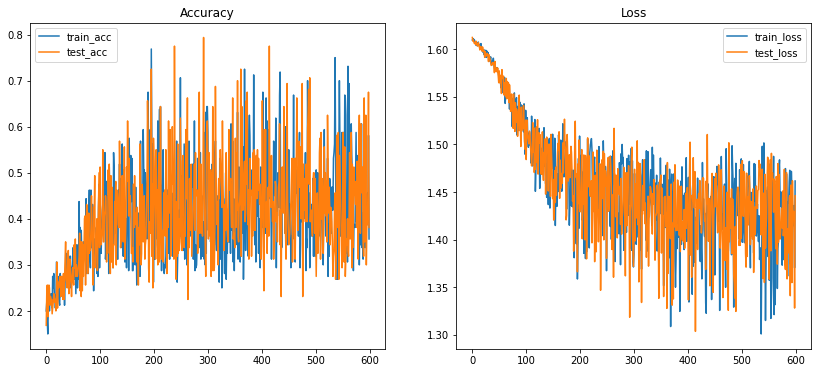

In [ ]:
# Training loop
with tqdm(zip(train_dataloader, val_dataloader), total=args.num_task_batch_train) as pbar: 
    train_accuracies = []       
    val_accuracies = []       
    train_losses = []       
    val_losses = []
           
    for task_batch_idx, (train_batch, val_batch) in enumerate(pbar):
        if task_batch_idx >= args.num_task_batch_train:
            break

        train_accuracy, train_loss = train_MANN(args, train_batch, model, criterion, optimizer)
        val_accuracy, val_loss = test_MANN(args, val_batch, model, criterion, optimizer)
        
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        pbar.set_postfix(train_accuracy='{0:.4f}'.format(train_accuracy),
                            val_accuracy='{0:.4f}'.format(val_accuracy),
                            train_loss='{0:.4f}'.format(train_loss),
                            val_loss='{0:.4f}'.format(val_loss)
                            )                

    # save model
    save_model(args, model, 'MANN.th')  
    print_graph(train_accuracies, val_accuracies, train_losses, val_losses)  

In [ ]:
# load model
load_model(args, model, 'MANN.th')

# Testing loop
with tqdm(test_dataloader, total=args.num_task_batch_test) as pbar: 
    sum_test_accuracies = 0.0
    sum_test_losses = 0.0
           
    for task_batch_idx, test_batch in enumerate(pbar):
        if task_batch_idx >= args.num_task_batch_test:
            break

        test_accuracy, test_loss = test_MANN(args, test_batch, model, criterion, optimizer)
        
        sum_test_accuracies += test_accuracy
        sum_test_losses += test_loss 
        pbar.set_postfix(test_accuracy='{0:.4f}'.format(sum_test_accuracies / (task_batch_idx + 1)),
                         test_loss='{0:.4f}'.format(sum_test_losses / (task_batch_idx + 1))
                         )                

Load model


100%|██████████| 200/200 [00:57<00:00,  3.48it/s, test_accuracy=0.4553, test_loss=1.4150]


In [ ]:
args = easydict.EasyDict({
    "folder": 'dataset',
    "download": True,
    "num_shots": 1,
    "num_ways": 5,
    "output_folder": 'model',
    "task_batch_size": 32,           # 필수
    "num_task_batch_train": 6000,  # 필수
    "num_task_batch_test": 2000,   # 필수
    "device": 'cuda',           # 필수
})
train_dataloader, test_dataloader, val_dataloader = get_dataloader(args)    
model = NTM(args.num_ways).to(device=args.device)
                    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), 
                                momentum=0.9, 
                                alpha=0.95, 
                                lr=1e-4)

# Training loop
with tqdm(zip(train_dataloader, val_dataloader), 
          total=args.num_task_batch_train) as pbar: 
    train_accuracies = []       
    val_accuracies = []       
    train_losses = []       
    val_losses = []
        
    for task_batch_idx, (train_batch, val_batch) in enumerate(pbar):
        if task_batch_idx >= args.num_task_batch_train:
            break
        train_accuracy, train_loss = train_MANN(args, 
                                                train_batch, 
                                                model, 
                                                criterion, 
                                                optimizer)
        val_accuracy, val_loss = test_MANN(args, 
                                           val_batch, 
                                           model, 
                                           criterion, 
                                           optimizer)
        
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        pbar.set_postfix(train_accuracy='{0:.4f}'.format(train_accuracy),
                            val_accuracy='{0:.4f}'.format(val_accuracy),
                            train_loss='{0:.4f}'.format(train_loss),
                            val_loss='{0:.4f}'.format(val_loss)
                            )                
# save model
save_model(args, model, 'MANN.th')  
print_graph(train_accuracies, val_accuracies, train_losses, val_losses)  

# load model
load_model(args, model, 'MANN.th')

# Testing loop
with tqdm(test_dataloader, total=args.num_task_batch_test) as pbar: 
    sum_test_accuracies = 0.0
    sum_test_losses = 0.0
        
    for task_batch_idx, test_batch in enumerate(pbar):
        if task_batch_idx >= args.num_task_batch_test:
            break
        test_accuracy, test_loss = test_MANN(args, 
                                             test_batch, 
                                             model, 
                                             criterion, 
                                             optimizer)
        
        sum_test_accuracies += test_accuracy
        sum_test_losses += test_loss 
        pbar.set_postfix(test_accuracy='{0:.4f}'.format(sum_test_accuracies 
                                                        / (task_batch_idx + 1)),
                        test_loss='{0:.4f}'.format(sum_test_losses 
                                                   / (task_batch_idx + 1))
                        ) 